# Voter Turnout and Demographics in Massachusetts (Milestone 5)

*Max Bahar, Stefan Chu, Ted McCulloch*

## Dependencies

This notebook relies on the following libraries:
- `GeoPandas`: For manipulation and processing of geographic data. 
- `NumPy`: For its various uses in data manipulation.
- `SHAP`: To assess feature importance.
- `scikit-learn`: For the models, metrics, and scaling.

Data processing and plotting functions can be found in the accompanying `utils.py` file.

## Model Illustration

This is an illustration of the notebook's workflow:

![Model flowchart](../images/model-flowchart.png)

In [2]:
# Imports
import geopandas as gpd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Import our utilities
from utils import *

# Specify global variables
RANDOM_STATE = 0
DATA_PATH = "../data/block_groups.geojson"
RF_IMP_THRESH = 0.025

## Table of Contents

(Adding this so I don't forget)

1. [Problem Statement](#1-problem-statement)
2. [Data](#2--data)
3. [EDA](#3-eda)

## 1 | Problem Statement

### 1a | Motivation



### 1b | Context

Voter turnout reflects the health of a democratic system, measuring the participation of its members in the electoral process.  However, it is widely documented that voter turnout varies significantly across demographic groups such as age, race, education, and income. Research finds that nonvoters are more likely to be younger, identify as non-White, have low education, and come from low income households ([Pew Research Group, 2023](https://www.pewresearch.org/politics/2023/07/12/voter-turnout-2018-2022/)). Further understanding these patterns is crucial for identifying barriers to participation and designing policies to improve turnout ([MIT, 2021](https://electionlab.mit.edu/research/voter-turnout)).

This project explores the predictive power of voter characteristics on voter turnout for the 2020 presidential election in the state of Massachusetts. By leveraging Census Block Group data, this study aims to uncover localized patterns that aggregate county or state-level studies ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)) or individual-level studies ([Kim, 2024](https://link.springer.com/article/10.1007/s11109-022-09816-z#Sec14)) may overlook.

### 1c | Problem Framing

**How do different voter characteristics influence voter turnout in Massachusetts?**

## 2 | Data

### 2a | Description

To answer this question, we use voter turnout data at the Census Block level sourced from L2 Data and Redistricting Data Hub.

### 2b | Data Handling

We applied several processing steps which included:
1. Dropped observations without Census Block IDs that were instead aggregated to the County level (73,811 or ~1.60% of total voters). Disaggregating these observations necessitated the assumption that demographic characteristics are uniformly distributed across the County, which is false.
2. Aggregated the Census Block data to the Census Block Group level to reduce the high variance of registered voter counts in each observation.
3. During the aggregation process, we also imputed mean household income by taking the weighted mean of mean household income at the Census Block level, weighted by the number of voters registered.
4. Converted demographic predictors from counts of voters to proportion of voters. We did this to account for differences in the number of voters that lived in each Census Block Group (a Census Block Group in a city will likely have a higher voter count than a Census Block Group in rural Massachusetts).

Our response variable is the proportion of registered voters that voted in the 2020 presidential election, denoted as `2020_turnout_pct`.

Our predictors include the total number of voters registered, mean household income, and the proportion of people with specific characteristics such as age; ethnicity; party affiliation; and language.

In [3]:
# Read in the data
voter_gdf = gpd.read_file(DATA_PATH)

## 3 | EDA

### 3a | Voter Turnout Distribution

We find that the majority of block groups have a relatively high voter turnout (greater than 70%), but that there is a long tail to the left, indicating that there are block groups with significantly lower voter turnout.

We also see that the distribution of the number of voters registered looks approximately normally distributed, which is why we use StandardScaler to scale for our baseline linear regression model.

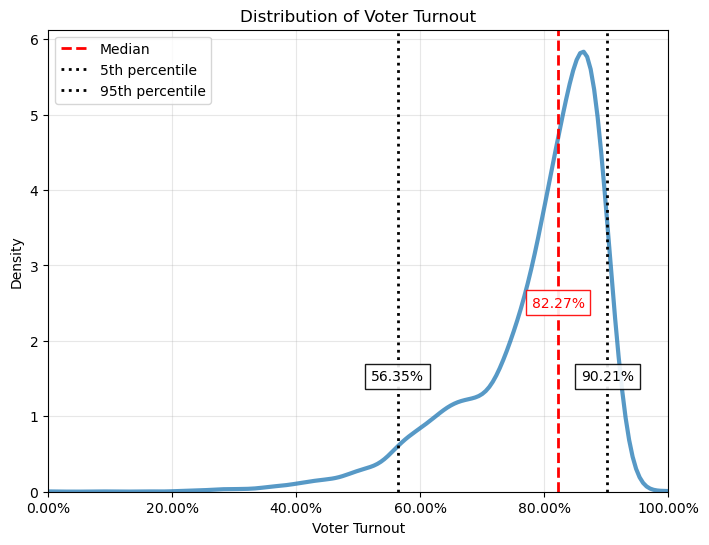

In [4]:
plot_dist(voter_gdf, "Distribution of Voter Turnout", 
         "2020_turnout_pct", "Voter Turnout", "Density",
         "{:.2%}", [0.24,0.4,0.24])

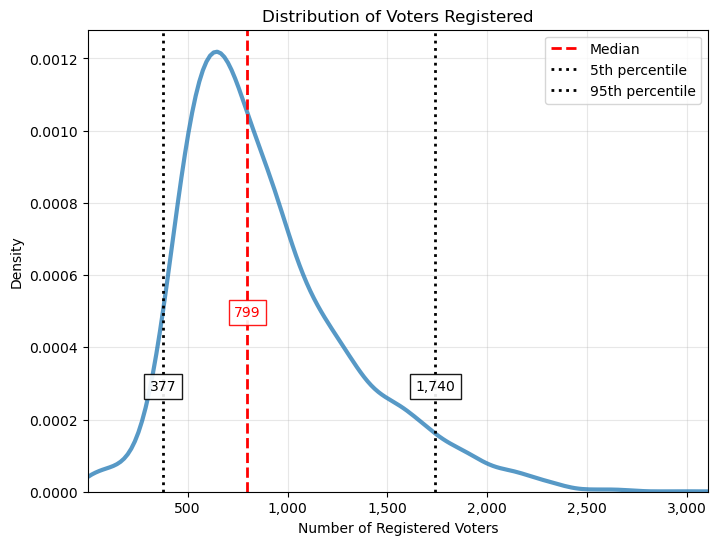

In [5]:
plot_dist(voter_gdf, "Distribution of Voters Registered", 
         "total_reg", "Number of Registered Voters", "Density",
         "{:,.0f}", [0.22,0.38,0.22])

### 3b | Voter Turnout by Income

Similar to the number of registered voters, in plotting the distribution of mean household income, we can see that it is approximately normally distributed. For this reason, we chose to use StandardScaler when using this predictor in the linear regression model.

We also see a negative relationship between voter turnout and mean household income where block groups with higher/lower income have higher/lower voter turnout on average. However, it does not look like this relationship is perfectly linear, which is why we opted for the tree-based random forest model.

We can also expect to see multicollinearity with mean household income and other variables such as the proportion of voters of a certain ethnicity. For example, on average, block groups with higher proportion of ethnically European voters have higher mean household income. On the other hand, block groups with higher proportion of Hispanic voters will have lower mean household income.

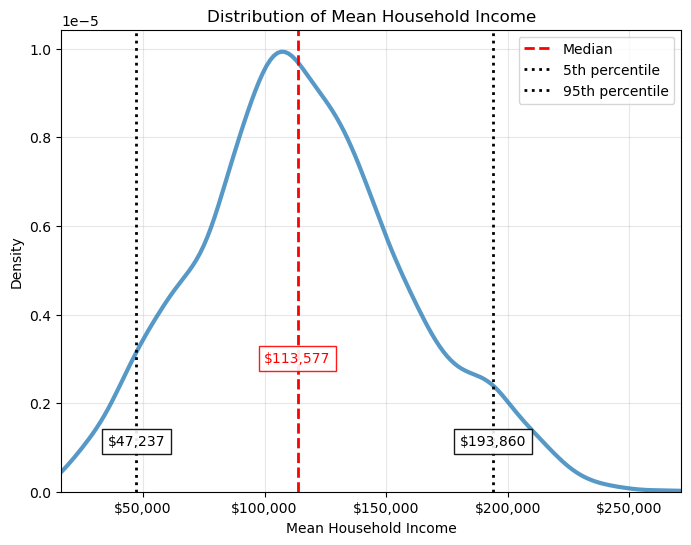

In [6]:
plot_dist(voter_gdf, "Distribution of Mean Household Income", 
         "mean_hh_income", "Mean Household Income", "Density",
         "${:,.0f}", [0.1,0.28,0.1])

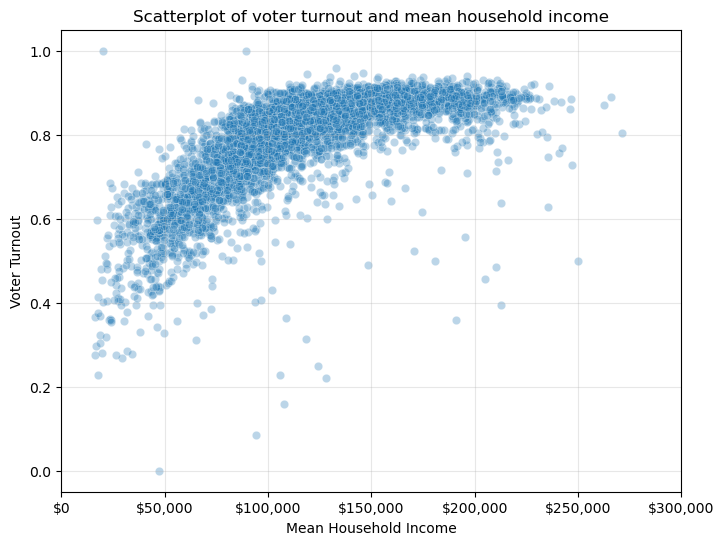

In [7]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and mean household income", 
            "mean_hh_income", "2020_turnout_pct", 
            "Mean Household Income", "Voter Turnout", "${:,.0f}")

### 3c | Voter Turnout by Ethnicity

We see that as the proportion of ethnically European voters in the Block Group increases, voter turnout increases. On the other hand, as the proportion of Hispanic voters in the Block Group increases, voter turnout decreases.

There is a slightly less pronounced negative correlation between the proportion of African American voters and voter turnout.

The categories "Other" and East and South Asian represent very little of the registered voter population.

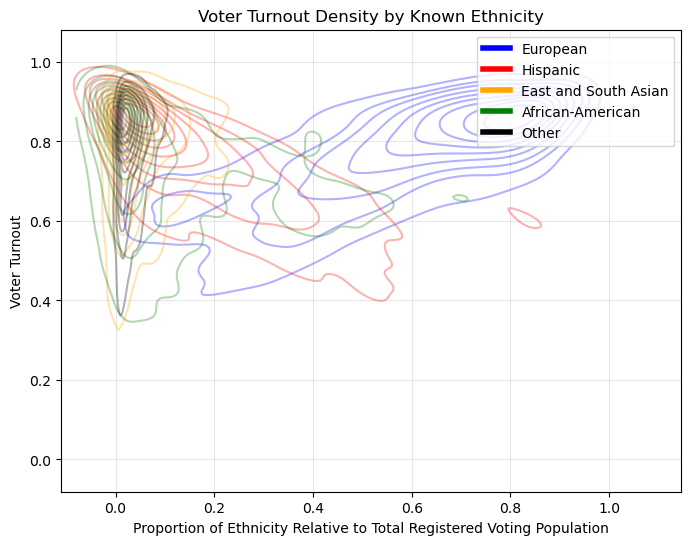

In [8]:
plot_KDE(voter_gdf, 'Voter Turnout Density by Known Ethnicity',
        ['eth1_eur','eth1_hisp', 'eth1_esa', 'eth1_aa','eth1_oth'],
        ['European', 'Hispanic',  'East and South Asian', 'African-American',  'Other'],
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Ethnicity')

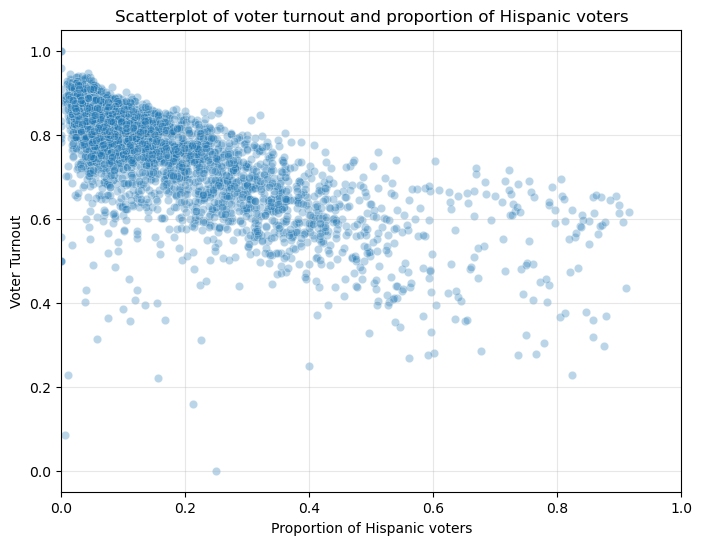

In [9]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and proportion of Hispanic voters", 
            "eth1_hisp", "2020_turnout_pct", 
            "Proportion of Hispanic voters", "Voter Turnout", "{:.1f}")

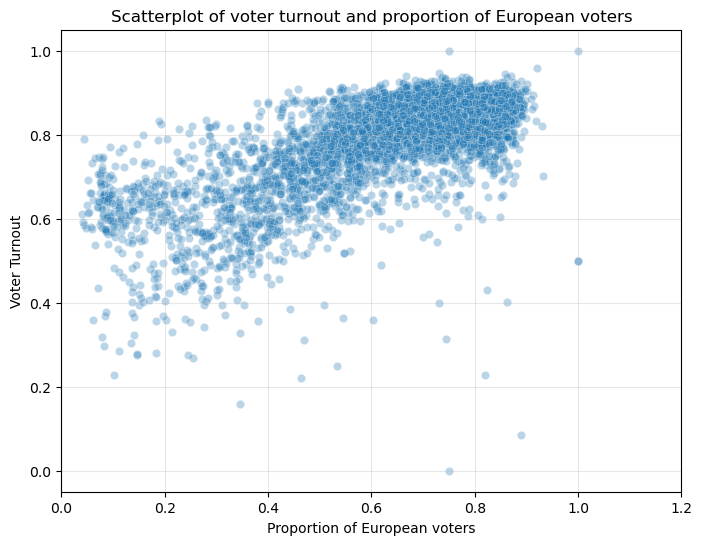

In [10]:
plot_scatter(voter_gdf, "Scatterplot of voter turnout and proportion of European voters", 
            "eth1_eur", "2020_turnout_pct", 
            "Proportion of European voters", "Voter Turnout", "{:.1f}")

### 3d | Voter Turnout by Party

Of the parties, Non-Partisan, Democrat, and Republican were the most prevalent, with NP actually representing the majority of registered voters in all counties. Republicans make up the minority of registered voters which is why they are gathered on the far left of the plot; the opposite is true for NP. The densest areas of the KDE plot differ greatly on the x-axis but are actually similiar in terms of voter turnout. 

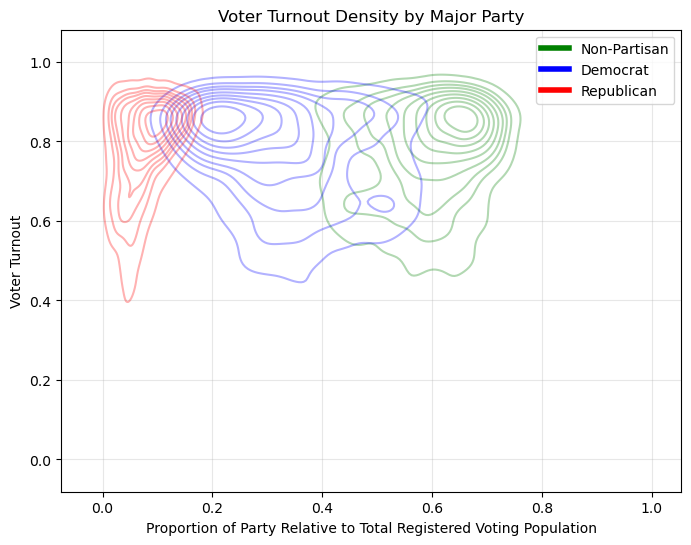

In [11]:
plot_KDE(voter_gdf, 'Voter Turnout Density by Major Party',
        ['party_npp', 'party_dem', 'party_rep'],
        ['Non-Partisan', 'Democrat', 'Republican'],
        ['green','blue','red'],
        'Party')

### 3e | Voter Turnout by Age

The 

Here we can observe the following trends
1. 35-64 grouping is over-represented in the population of registered voters
2. 18-24 alternatively are under-represented in teh population of registered voters
3. There appears to be a positive relationship with voters 65+ and voter turnout

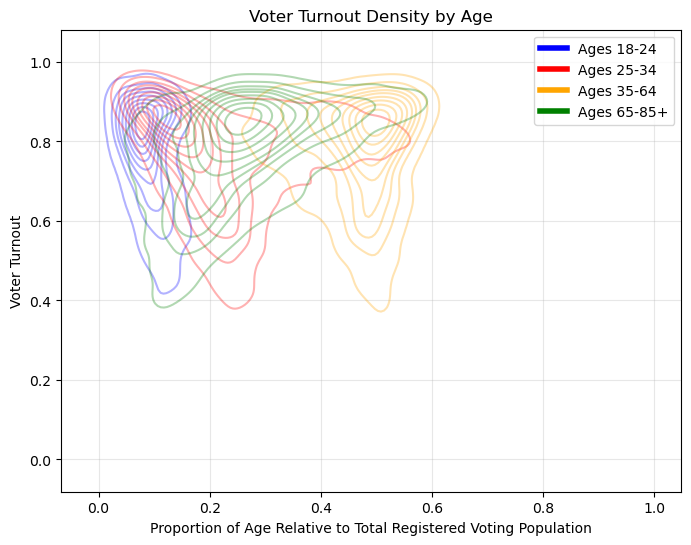

In [12]:
# Group together age bins for better visualization
voter_gdf["age_18_24"] = voter_gdf["age_18_19"]+ voter_gdf["age_20_24"]
voter_gdf["age_25_34"] = voter_gdf["age_25_29"]+ voter_gdf["age_30_34"]
voter_gdf["age_35_64"] = voter_gdf["age_35_44"]+ voter_gdf["age_45_54"]+ voter_gdf["age_55_64"]
voter_gdf["age_65_85over"] = voter_gdf["age_65_74"]+ voter_gdf["age_75_84"] + voter_gdf["age_85over"]

plot_KDE(voter_gdf, 'Voter Turnout Density by Age', 
        ['age_18_24','age_25_34', 'age_35_64', 'age_65_85over'], 
        ['Ages 18-24', 'Ages 25-34',  'Ages 35-64', 'Ages 65-85+'] ,  
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Age')

### 3f | Voter Turnout by Language

"English" and "Unknown" dominate the majority of the labels for language, with the two categories being nearly perfectly negatively correlated. This suggests that L2 Data was unable to obtain the specific language spoken for non-English speaking voters.

There is a clear positive correlation between more English dense blocks and higher voter turnout and a clear negative correlation between "Unknown" dense blocks and lower voter turnout.

We believe that "Unknown" category can be classified as Missing at Random (MAR); we know that English speaking dense blocks tend to have higher voter turnout. Therefore, it is very likely that "unknown" is overrepresented by non-english speakers. 

Corroborating our findings that voter turnout is negatively correlated with Hispanic ethnicity, we see a negative correlation between Spanish and Portugese speakers and voter turnout.





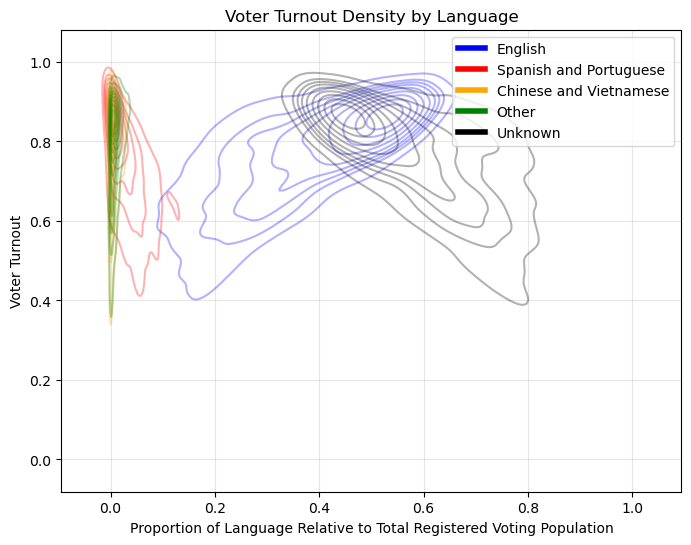

In [13]:
# Group together spanish+portuguese and vietnamese+chinese for better visualization
voter_gdf["lang_spanish_portuguese"] =voter_gdf["lang_spanish"]+voter_gdf["lang_portuguese"]
voter_gdf["lang_chinese_vietnamese"] = voter_gdf["lang_chinese"] + voter_gdf["lang_vietnamese"]
plot_KDE(voter_gdf, 'Voter Turnout Density by Language',
        ['lang_english','lang_spanish_portuguese','lang_chinese_vietnamese','lang_other', 'lang_unknown'],
        ['English', 'Spanish and Portuguese',  'Chinese and Vietnamese', 'Other', 'Unknown'], 
        ['blue','red', 'orange', 'green', 'black', 'gray'],
        'Language')

### 3g | Correlation Matrix

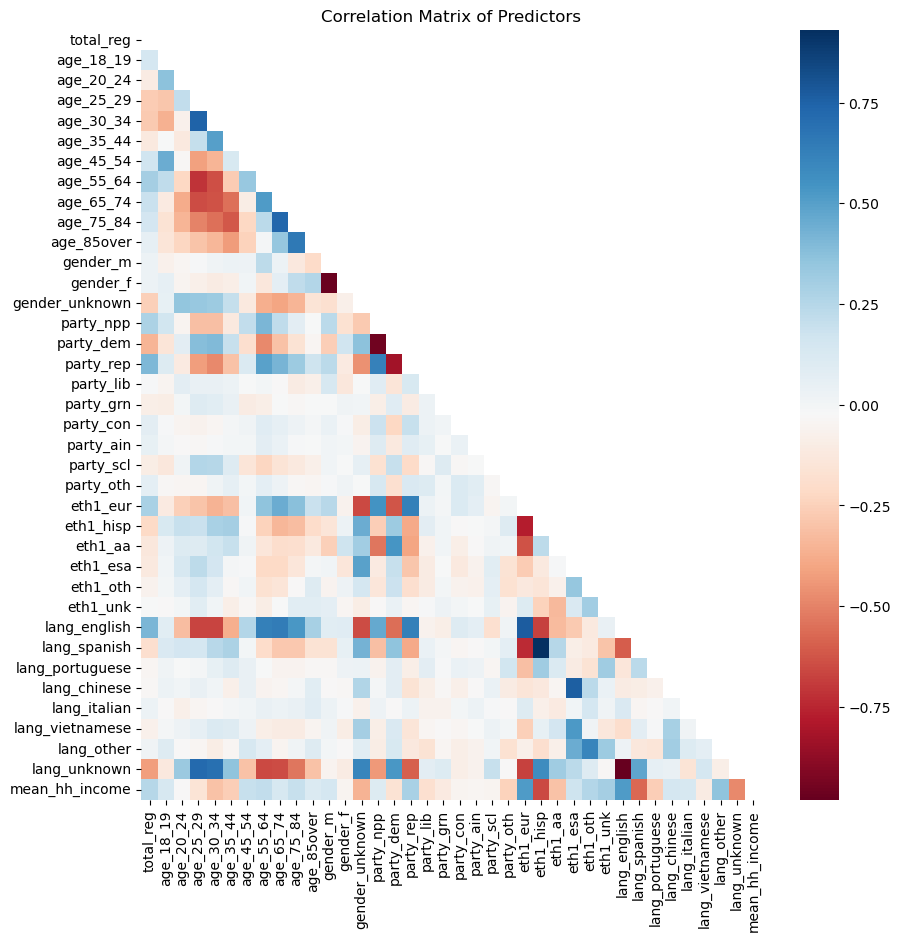

In [14]:
plot_corr_matrix(voter_gdf, "Correlation Matrix of Predictors", PREDICTORS)

## 4 | Modeling

In all models, we use Census Block Group data on the number of voters registered, mean household income, and proportions of age; gender; party affiliation; ethnicity; and language spoken.

Our choice in using demographic proportions instead of counts is in line with existing research on voter turnout and demographics ([Ansolabehere et al., 2024](https://hdsr.mitpress.mit.edu/pub/0c5ylgo1/release/2)).

We used 80% of the Census Block Groups to train and the remainder 20% for the test set.

For each model we tried, we report the train and test MSE and R-squared scores below, which we will use to compare their performance.

To tackle multicollinearity and perform feature selection, we calculate the permutation importance of all the models, examining the importance of specific features for voter turnout.

### 4a | Baseline Linear Regression

As our baseline model, we utilized all 38 predictors in a multiple linear regression model.

Since linear regression is sensitive to scale, we used StandardScaler to scale mean household income and the number of voters registered in each Census Block Group (due to these variables being approximately normally distributed).

We report the train and test MSE and R-squared scores below, which we will use to compare our future models.

In [15]:
# Define X and y 
X = voter_gdf[PREDICTORS].copy()
y = voter_gdf["2020_turnout_pct"].copy()

# Specify KFold object for validation splits
kf = KFold(10, shuffle=True, random_state=RANDOM_STATE)

# StandardScaler for total_reg and mean_hh_income
X[['total_reg','mean_hh_income']] = StandardScaler().fit_transform(X=X[['total_reg','mean_hh_income']])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

In [16]:
# Fit model
linreg = LinearRegression().fit(X_train,y_train)

# Report accuracy
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

	Train		Test
MSE	0.00215		0.00246
R2	0.82778		0.81028


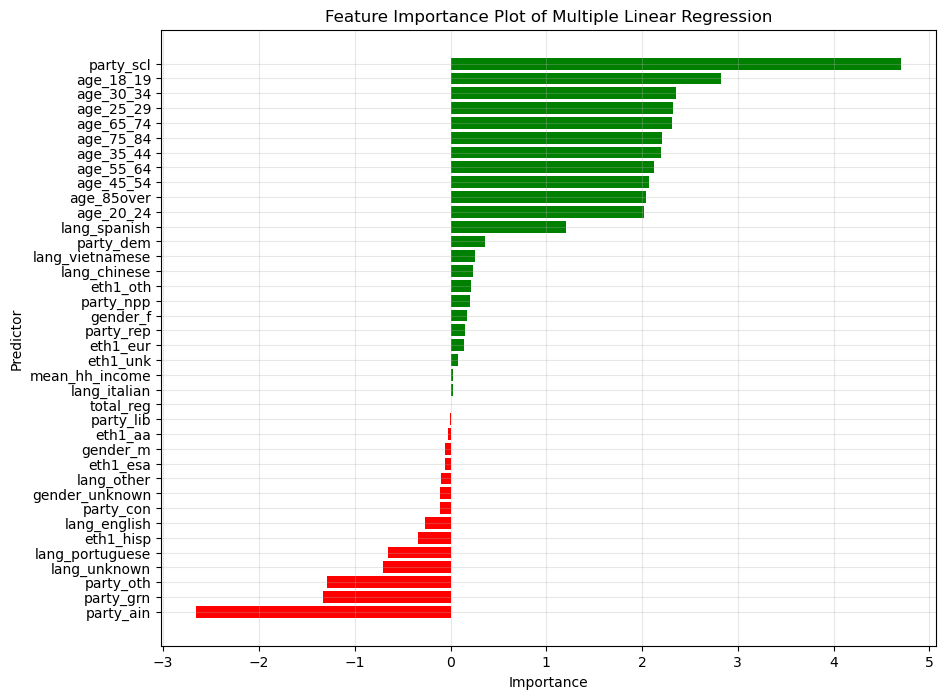

In [17]:
linreg_coef = gather_plot_importance(linreg, "Multiple Linear Regression")

Our Multiple Linear Regression model indicated that the following features has a positive association with voter turnout (ordred from most important/highest beta to least important/lowest beta). This means that having higher proportions of these populations are projected to increase voter turnout.
1. socialist party
2. any age group
3. spanish language
4. democratic party
5. Vietnamese language
6. Chinese language
7. "other" ethnicity
8. non-partisan registration
9. female gender/sex
10. republican party
11. European ethnicity 
12. "unknown" ethnicity
13. mean income

It identified the following features as having a negative association with voter turnout (ordered from most to least important). This means that having higher proportions of these populations are projected to decrease voter turnout.
1. American Ind. Party
2. Green party
3. "other" party
4. "unknown" language label
5. Portuguese language
6. Hispanic ethnicity 
7. English language
8. Conservative party
9. unknown gender
10. "other" language
11. East and South Asian ethnicity
12. male gender/sex
13. African American ethnicity 
14. Libertarian party

Things that do make sense
1. Democratic party registration as democrats did win every county
2. female sex/gender. Women make up a slight majority of registered voters in every county. 
3. European ethnicity having a positive association is consistent with our EDA
4. Hispanic ethnicity having a negative assocation is consistent with our EDA

Things that don't make sense
1. all ages groups having a positive association. Existing research on the subject posits that younger voters tend to have lower voter turnout, so it's concerning that 18-19 are leading in the langauge categories. 
2. Spanish language - we observed in our EDA a clear negative correlation between spanish speaking and voter turnout.
3. mean income having a low value is inconsistent with our EDA, we would expect to see a coefficient with a higher magnitude associated with this predictor.

We believe these results that are inconsistent with the literature and our EDA are due to multicollinearity between several predictors. For example, "English" and "Unknown Language" are almost perfectly negatively correlated. This multicollinearity have likely influenced the beta coefficients in the baseline model.

### 4b | Linear Model Feature Selection

We use LASSO regularized linear regression with all 38 predictors to tackle multicollinearity and identify important predictors.

In [18]:
# Use CV to select best alpha/lambda value lasso model
lasso_alphas = np.logspace(-4, 0, 1000)
lasso = LassoCV(alphas=lasso_alphas, cv=kf, max_iter=1000).fit(X_train, y_train)
lasso_a = lasso.alpha_
print(f'LASSO with alpha={lasso_a:.5f}: {lasso.score(X_test, y_test):.3}')

# fit with CV alpha
lasso_cv = Lasso(alpha=lasso_a).fit(X_train, y_train)

# Report accuracy
y_pred_train = lasso_cv.predict(X_train)
y_pred_test = lasso_cv.predict(X_test)

# Print scores
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")


LASSO with alpha=0.00010: 0.798
	Train		Test
MSE	0.00246		0.00261
R2	0.80265		0.79829


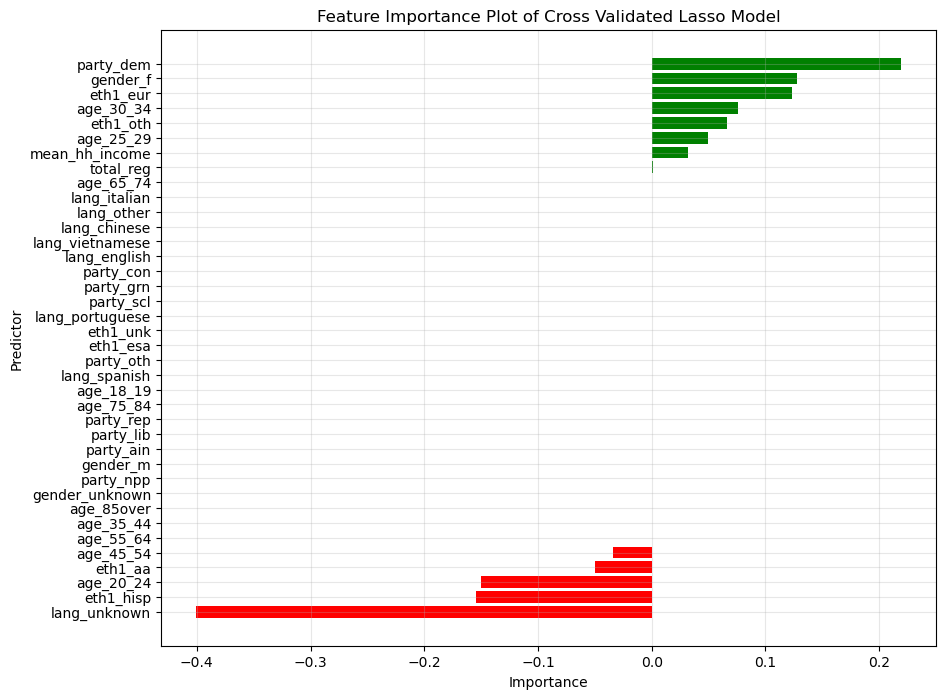

In [19]:
coef_df_lasso = gather_plot_importance(lasso_cv, "Cross Validated Lasso Model")
predictors_lasso = coef_df_lasso[coef_df_lasso["Importance"] != 0]["Predictor"].to_list()

Based on the plot above of the LASSO regularized regression, the model identified 12 features that are relevant (beta coefficients not equal to 0).

Features with positive association with higher voter turnout
1. Democratic Party registration
2. female gender
3. European ethnicity
4. Age group 30-34
5. age group 25-29
6. higher mean income
7. total registered voters

Features with negative association with higher voter turnout
1. Unknown language label
2. Hispanic ethnicity 
3. Age group 20-24
4. African American ethnicity 
5. Age grop 45-54

These 12 features identified as important by the LASSO model make more sense in the context of our EDA and the existing literature on voter turnout and demographics.

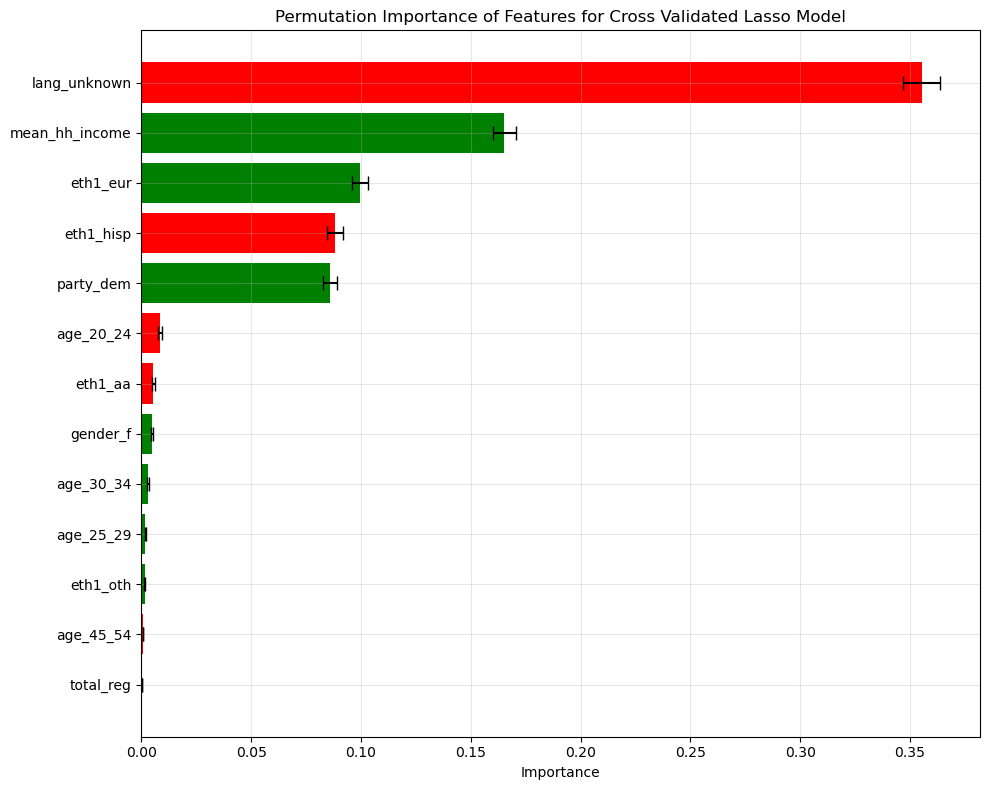

In [20]:
# Plot permutation importance
lasso_perm = gather_perm_importance(lasso_cv, X_train, y_train, "Cross Validated Lasso Model", 100)
predictors_perm = lasso_perm["Predictor"].to_list()

From the plot above, we can tell that unknown language labeling, mean income, and European ethnicity are strongly correlated with the target variable of voter turnout (negative and positive impact) since disrupting their values results in a large drop in model performance

Most Important Positive Beta Features
1. Mean Income
2. European Ethnicity 
3. Democratic Party Registration

Most important Negative Beta Features
1. Unknown language label 
2. Hispanic idenity 

This somewhat confirms the results of the LASSO model, with unknown language labeling, European ethnicity, and Hispanic ethnicity marked as important in both permutation importance and LASSO.

On the other hand, female voters, voters aged 30-34, and voters aged 20-24 seemed more important in the LASSO model results than the permutation importance results. 

**Conclusions**

Based on the LASSO model and permutation importance results, we find evidence that the following variables are most important in predicting voter turnout at the Census block group level:
1. Unknown Language Labeling: Since this variable is negatively correlated with the proportion of English-speaking voters, we believe the importance of this variable highlights that block groups with a low proportion of English-speaking voters are associated with lower voter turnout.
2. Mean Household Income: As indicated by our EDA, a higher mean household income is associated with higher voter turnout.
3. European ethnicity and Hispanic ethnicity: Also hinted at by our EDA, a higher proportion of White voters is associated with higher voter turnout and a higher proportion of Hispanic voters is associated with lower voter turnout.
4. Ages 20-34: Interestingly, a higher proportion of voters aged 20-24 is associated with lower voter turnout, while a higher proportion of voters aged 25-34 is associated with higher voter turnout. 

The LASSO model results helped us identify the most important features in predicting voter turnout, however it still assumes a linear relationship between the variables. Additionally, the results of our baseline linear regression and our EDA suggests that there is multicollinearity between several of the variables in the dataset. To address these issues, we turned to a random forest model. The tree-based model can capture complex, non-linear relationships between the predictors and voter turnout. Furthermore, the model is less affected by multicollinearity, which is especially relevant given our dataset.

### 4c | Random Forest Model Feature Selection

In [21]:
# Define X and y 
X = voter_gdf[PREDICTORS].copy()
y = voter_gdf["2020_turnout_pct"].copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

# Specify parameter grid to search
param_grid = {
    "n_estimators" : [50, 100, 150],
    "max_depth" : [15, 20, 25, None],
    "min_samples_split" : [2, 5],
    "min_samples_leaf" : [1, 2, 5],
    "max_features" : ["sqrt","log2"]
}

In [22]:
# Random search
random_search = RandomizedSearchCV(RandomForestRegressor(
    warm_start=True,
    oob_score=True,
    random_state=RANDOM_STATE), # Set this to false for deterministic behavior
        param_grid, 
        cv=kf, 
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
        n_iter=50
)
random_search.fit(X_train, y_train)

# Print best parameters:
print("The best parameters for 38 predictors are:")
for param,val in random_search.best_params_.items():
    print(f"{param}: {val}")

# Fit the random forest without tuning hyperparameters
rf_cv =  RandomForestRegressor(**random_search.best_params_, random_state=RANDOM_STATE)
rf_cv.fit(X_train, y_train)

# Report scores
y_pred_train = rf_cv.predict(X_train)
y_pred_test = rf_cv.predict(X_test)

print(f'Random Forest with all 38 predictors')
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

The best parameters for 38 predictors are:
n_estimators: 100
min_samples_split: 5
min_samples_leaf: 1
max_features: sqrt
max_depth: 20
Random Forest with all 38 predictors
	Train		Test
MSE	0.00038		0.00185
R2	0.96974		0.85717


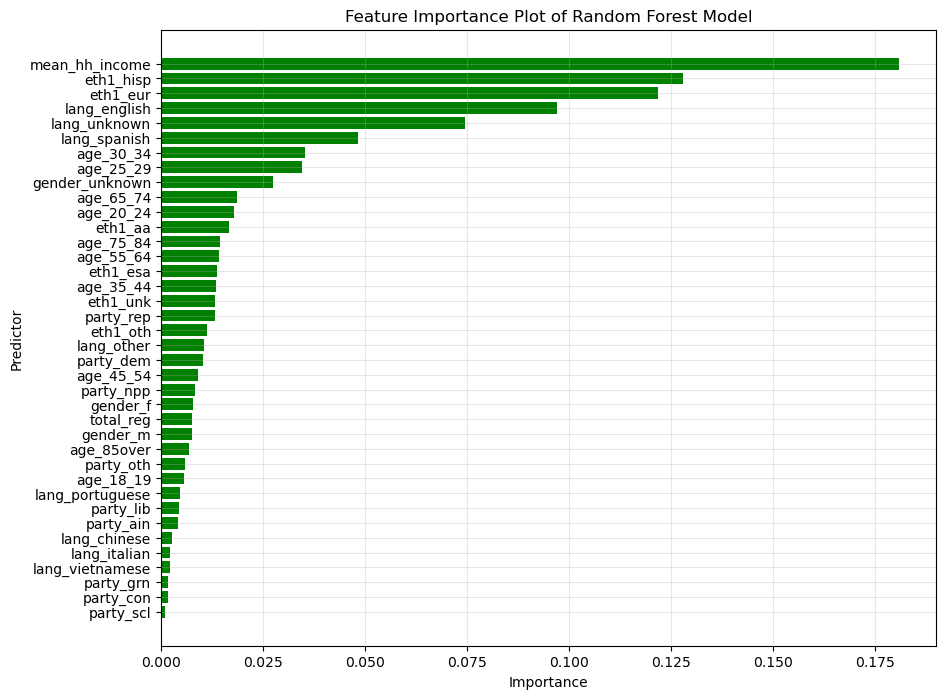

['gender_unknown', 'age_25_29', 'age_30_34', 'lang_spanish', 'lang_unknown', 'lang_english', 'eth1_eur', 'eth1_hisp', 'mean_hh_income']


In [23]:
# Plot feature importance
rf_importance = gather_plot_importance(rf_cv, "Random Forest Model")
rf_imp_predictors = rf_importance[rf_importance["Importance"] >= RF_IMP_THRESH]["Predictor"].to_list()
print(rf_imp_predictors)

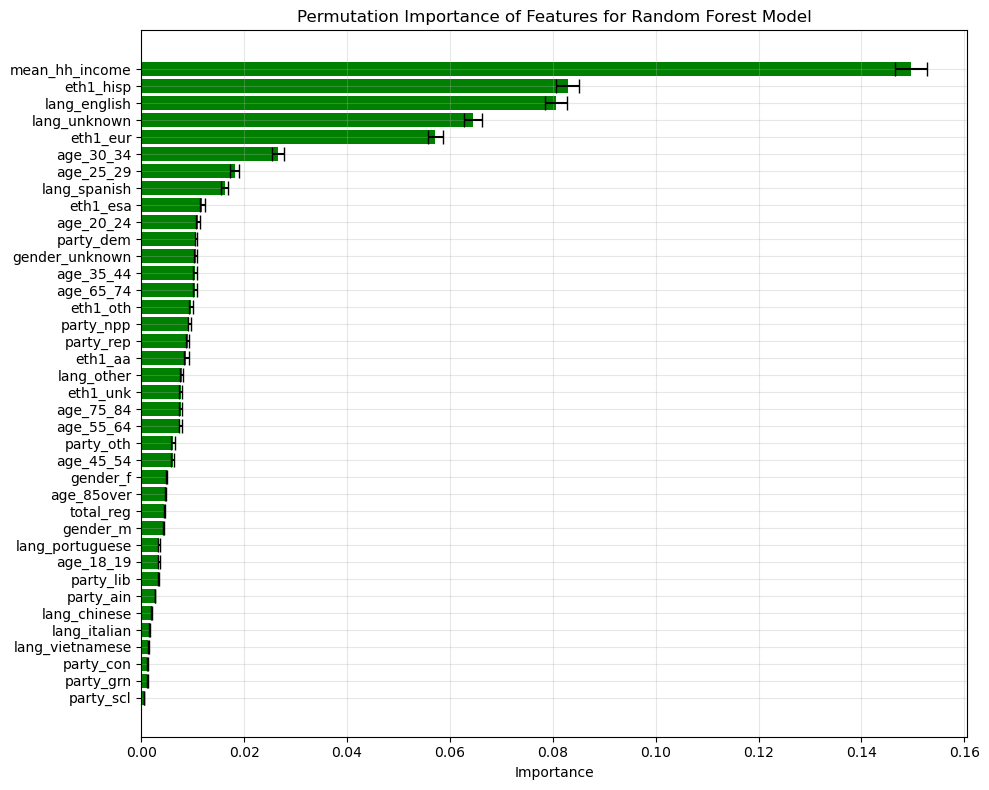

['mean_hh_income', 'eth1_hisp', 'lang_english', 'lang_unknown', 'eth1_eur', 'age_30_34', 'age_25_29', 'lang_spanish', 'gender_unknown']


In [24]:
# Plot permutation importance for 100 iterations
rf_perm = gather_perm_importance(rf_cv, X_train, y_train, "Random Forest Model", n_repeats=100, random_state=RANDOM_STATE)
rf_perm_predictors = rf_perm[rf_perm["Importance"] >= RF_IMP_THRESH]["Predictor"].to_list()
print(rf_perm_predictors)

In [25]:
# Collect features
predictors_linear = sorted(set([*predictors_lasso, *predictors_perm]))
predictors_rf = sorted(set([*rf_imp_predictors, *rf_perm_predictors]))
predictors_subset = sorted(set([*predictors_linear, *predictors_rf]))

# Report features
print(f"Identified {len(predictors_linear)} important predictors from linear model:")
print(predictors_linear)
print(f"Identified {len(predictors_rf)} important predictors from random forest model:")
print(predictors_rf)
print(f"Identified {len(predictors_subset)} important predictors:")
print(predictors_subset)

Identified 13 important predictors from linear model:
['age_20_24', 'age_25_29', 'age_30_34', 'age_45_54', 'eth1_aa', 'eth1_eur', 'eth1_hisp', 'eth1_oth', 'gender_f', 'lang_unknown', 'mean_hh_income', 'party_dem', 'total_reg']
Identified 9 important predictors from random forest model:
['age_25_29', 'age_30_34', 'eth1_eur', 'eth1_hisp', 'gender_unknown', 'lang_english', 'lang_spanish', 'lang_unknown', 'mean_hh_income']
Identified 16 important predictors:
['age_20_24', 'age_25_29', 'age_30_34', 'age_45_54', 'eth1_aa', 'eth1_eur', 'eth1_hisp', 'eth1_oth', 'gender_f', 'gender_unknown', 'lang_english', 'lang_spanish', 'lang_unknown', 'mean_hh_income', 'party_dem', 'total_reg']


### 4d | Final Random Forest Model

In [26]:
# Random search
random_search = RandomizedSearchCV(RandomForestRegressor(
    random_state=RANDOM_STATE, 
    warm_start=False), # Set this to false for deterministic behavior
        param_grid, 
        cv=kf, 
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
        n_iter=50
)
random_search.fit(X_train[predictors_linear], y_train)

# Print best parameters:
print(f"The best parameters for {len(predictors_linear)} predictors are:")
for param,val in random_search.best_params_.items():
    print(f"{param}: {val}")

# Fit the random forest without tuning hyperparameters
rf_cv = RandomForestRegressor(**random_search.best_params_, random_state=RANDOM_STATE)
rf_cv.fit(X_train[predictors_linear], y_train)

# Report scores
y_pred_train = rf_cv.predict(X_train[predictors_linear])
y_pred_test = rf_cv.predict(X_test[predictors_linear])

print(f'Random Forest with {len(predictors_linear)} predictors')
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

The best parameters for 13 predictors are:
n_estimators: 150
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
max_depth: 15
Random Forest with 13 predictors
	Train		Test
MSE	0.00032		0.00181
R2	0.97405		0.86036


## 5 | Results

### 5a | Linear Regression Conclusions

Based on the linear regression LASSO model and permutation importance results, we find evidence that the following variables are most important in predicting voter turnout at the Census block group level:
1. Unknown Language Labeling: Since this variable is negatively correlated with the proportion of English-speaking voters, we believe the importance of this variable highlights that block groups with a low proportion of English-speaking voters are associated with lower voter turnout.
2. Mean Household Income: As indicated by our EDA, a higher mean household income is associated with higher voter turnout.
3. European ethnicity and Hispanic ethnicity: Also hinted at by our EDA, a higher proportion of White voters is associated with higher voter turnout and a higher proportion of Hispanic voters is associated with lower voter turnout.
4. Ages 20-24 / 30-34: Interestingly, a higher proportion of voters aged 20-24 is associated with lower voter turnout, while a higher proportion of voters aged 30-34 is associated with higher voter turnout. 

The LASSO model results helped us identify the most important features in predicting voter turnout, however it still assumes a linear relationship between the variables. Additionally, the results of our baseline linear regression and our EDA suggests that there is multicollinearity between several of the variables in the dataset. To address these issues, we turned to a random forest model. The tree-based model can capture complex, non-linear relationships between the predictors and voter turnout. Furthermore, the model is less affected by multicollinearity, which is especially relevant given our dataset.

### 5b | SHAP Feature Importance

In [27]:
# Initialize the explainer
explainer = shap.TreeExplainer(rf_cv, X_train)
shap_values = explainer.shap_values(X_train)

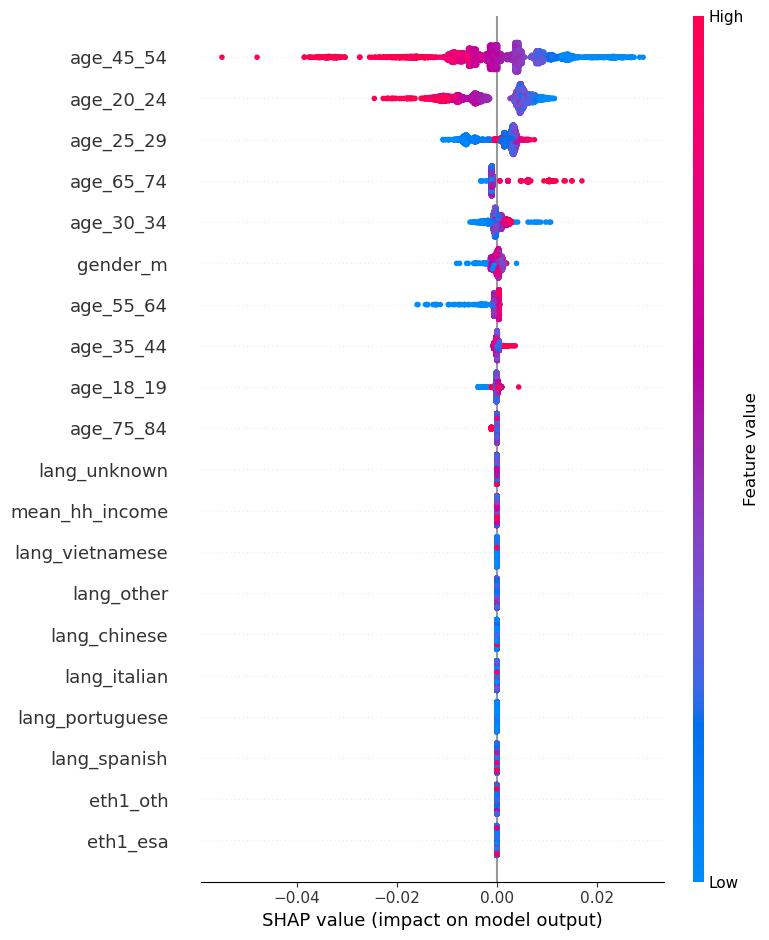

In [28]:
# Show the SHAP importance plot
shap.summary_plot(shap_values, X_train)

Based on the final Random Forest Regression model, we ran a SHAP (SHapley Additive exPlanations) summary plot to gain an understanding of the global feature importances. Shap values can be used to explain how much each feature influences the model towards predicting an outcome, allowing a limited amount of model interpretability. The beeswarm plot below orders the features by absolute mean shap value, allowing us to rank each feature's importance relative to the others. Red dots represent a high proportion of that feature, while blue dots represent a low proportion. Dots to the right of the line influence the model prediction positively, while dots to the left influence the model prediction negatively.

Mean Household Income: A higher mean household income is associated with higher voter turnout. This is the most important feature, influencing the model the most in both the positive and negative direction. One problem that this highlights in the 2020 election is that block groups with the lowest mean household incomes might not have been given the adequate support and resources to vote.

Unknown Language Labeling: This variable is negatively correlated with the proportion of English-speaking voters. This can be interpreted as a proxy variable for ethnicity in many block groups throughout Massachusetts. In fact, the model shows a negative correlation for blocks groups with a high proportion of Hispanic voters and low proportions of European voters. As stated before, because we are using proportions, the problem of multicollinearity comes up. A block group with a high proportion of Hispanic voters may be penalized  as much as 3x more by the model, since these three features are closely related. 

Ages 20-34: A higher proportion of voters aged 20-34 is associated with lower voter turnout, with the age 20-24 bracket being penalized by the model more significantly than ages 25-34. 

Democrat: A higher proportion of voters registered as Democrats is associated with higher voter turnout.

Female: Interestingly, a higher proportion of female voters is not particularly important to the model, but it does heavily penalize block groups with a low proportion of female voters. 

---
# DEV

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

In [30]:
gbr = GradientBoostingRegressor(
    random_state=RANDOM_STATE
).fit(X_train, y_train)

# Report scores
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

print(f'Gradient Boosting Regressor with all 38 predictors')
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

Gradient Boosting Regressor with all 38 predictors
	Train		Test
MSE	0.00092		0.00208
R2	0.92603		0.83960


In [31]:
gbr = GradientBoostingRegressor(
    random_state=RANDOM_STATE
).fit(X_train[predictors_linear], y_train)

# Report scores
y_pred_train = gbr.predict(X_train[predictors_linear])
y_pred_test = gbr.predict(X_test[predictors_linear])

print(f'Gradient Boosting Regressor with {len(predictors_linear)} predictors')
print("\tTrain\t\tTest")
print(f"MSE\t{mean_squared_error(y_train, y_pred_train):.5f}\t\t{mean_squared_error(y_test, y_pred_test):.5f}")
print(f"R2\t{r2_score(y_train, y_pred_train):.5f}\t\t{r2_score(y_test, y_pred_test):.5f}")

Gradient Boosting Regressor with 13 predictors
	Train		Test
MSE	0.00103		0.00184
R2	0.91783		0.85823
